In [1]:
import json 
import numpy as np 
import pandas as pd 

## Create a Markov N-gram language model 

In [2]:
data = "/Users/flint/Data/wordlists/generated/gpt-5000.json"
with open(data, 'r') as infile:
    docs = json.load(infile)

In [3]:
corpus = docs['corpus']
np.random.shuffle(corpus)
for document in corpus[:4]:
    print(document)

I am Henry and today I do.
I am Alice and today I be an adventurer and my journey is about a couple of adventurers and an explorer.
I am William and today I call you.
I am John and today I provide you with your services.


### Tokenizer

In [4]:
from nltk.tokenize import word_tokenize

In [5]:
def tokenizer(text):
    return ['#S'] + word_tokenize(text.lower()) + ['#E']

In [6]:
tokens = [tokenizer(doc) for doc in corpus]

## Marlov Language Model

In [7]:
from collections import defaultdict
import nltk 
from tqdm.notebook import tqdm
import numpy as np
from nlp.languagemodels import MarkovModel

In [8]:
model = MarkovModel(k=3)

In [9]:
model.read_multi(tokens)

100%|██████████| 4043/4043 [00:00<00:00, 27127.51it/s]


In [10]:
doc = model.generate(max_len=100)
print(" ".join(doc))

[PAD] #S i am william and today i break down a new song titled , the video , an inheritance to you the gift of my wife , and i try very hard to maintain my identity . you have a friend that 's been around my dog . #E


In [11]:
s = ["i am david and today i have a choice .", "the cat is on the table .", "i am william and i work on the table ."]
for x in s:
    tokens = tokenizer(x)
    print(x, model.eval_prob(tokens))

i am david and today i have a choice . -12.445900365412808
the cat is on the table . -73.68272297580945
i am william and i work on the table . -53.17286928272703


# MLM on real documents

In [12]:
from nlp.data import load_20news

In [13]:
data = load_20news()

In [14]:
corpus = [tokenizer(d) for d in data.data]

## Train class specific models

In [15]:
models = dict([(label, MarkovModel(k=3)) for label in data.target_names])

for i, doc in enumerate(corpus):
    c = data.target[i]
    label = data.target_names[c]
    models[label].read(doc)

In [17]:
" ".join(models['alt.atheism'].generate(max_len=20))

"[PAD] #S the amount of intrest they pay and in that we would n't be able to withstand the torture you may"

In [18]:
d = 340
doc = corpus[d]
c = data.target_names[data.target[d]]
print(doc)
print(c)

['#S', "g'day", 'all', ',', 'i', "'m", 'looking', 'for', 'a', 'program', 'to', 'convert', 'bmp', 'images', 'to', 'gif', ',', 'tga', 'or', 'even', 'ppm', '.', 'i', "'d", 'prefer', 'a', 'unix', 'program', ',', 'but', 'dos', 'is', 'fine', 'also', '.', 'i', "'ve", 'seen', 'alchemy', '(', 'for', 'dos', ')', 'and', 'some', 'windows', 'image', 'viewers', 'which', 'can', 'save', 'an', 'image', 'in', 'other', 'formats', ',', 'but', 'what', 'i', "'m", 'after', 'is', 'a', 'converter', 'not', 'a', 'viewer', '...', 'any', 'help', 'would', 'be', 'apprieciated', '!', 'cheers', 'stephen', '.', '#E']
comp.graphics


### Create a classifier

In [19]:
def predict(doc):
    predictions = np.zeros(len(data.target_names))
    for i, label in enumerate(data.target_names):
        m = models[label]
        predictions[i] = m.eval_prob(doc)
    return predictions 

In [20]:
y_pred = predict(doc)

In [24]:
data.target_names[np.argmax(y_pred)]

'comp.graphics'

In [26]:
predictions = np.array([predict(x) for x in corpus[:200]])

In [30]:
y_pred = np.argmax(predictions, axis=1)

In [32]:
y_truth = data.target[:200]

## Evaluation

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [34]:
print(classification_report(y_true=y_truth, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12
           2       1.00      0.92      0.96        13
           3       0.91      0.91      0.91        11
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         7
           7       0.56      1.00      0.72         9
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00         7
          10       1.00      0.92      0.96        13
          11       1.00      0.90      0.95        10
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         6
          15       1.00      0.90      0.95        10
          16       1.00      1.00      1.00         6
          17       1.00    

In [35]:
cm = confusion_matrix(y_truth, y_pred, labels=range(len(data.target_names)))

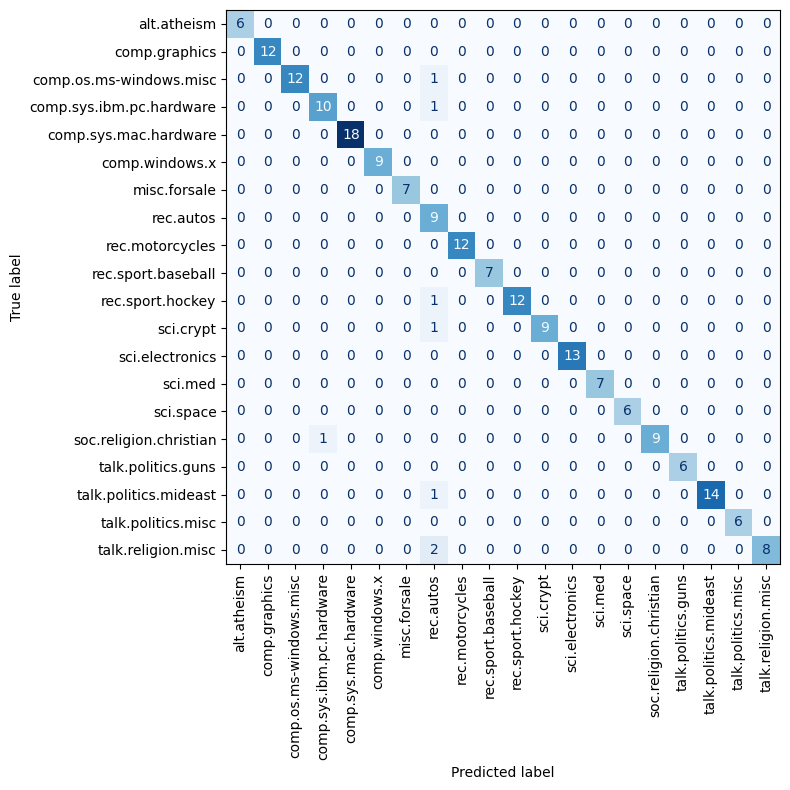

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()